# import libraries

In [1]:
import json
import numpy
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Define company name and date ranges

In [2]:
# CHANGE ME
COMPANY_IDENTIFIER = 'DW'
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

# check company licenses & downloand status

In [3]:
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

## licenses

In [4]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,MA,MR282376,Retailer,TDMA LLC,True,,MA-00115,Marijuana Retailer,72bb7c81-1893-4713-95f8-b61785d6ba15,None


## download summaries

In [5]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [6]:
def check_company_license_download(license_numbers: List[str],download_summary_records: List[Dict[str,str]]) -> Dict[str,str]:
    license_number_to_download_summary_records = {}

    for license_number in license_numbers:
        license_number_to_download_summary_records[license_number] = list(filter(
            lambda download_summary_record: download_summary_record['license_number'] == license_number,
            download_summary_records
        ))

    bad_count = 0
    bad_history = defaultdict(list)
    for license_number, download_summary_records in license_number_to_download_summary_records.items():
        print(f'Verifying download summaries for license {license_number}...')
        print(f'Earliest download summary: {download_summary_records[-1]["date"]}')
        print(f'Latest download summary: {download_summary_records[0]["date"]}')
        for download_summary_record in download_summary_records:
            if download_summary_record['status'] != 'completed':
                bad_count += 1
                print(f'Found bad download summary for license {license_number} on date {download_summary_record["date"]}') 
                bad_history[license_number].append(download_summary_record['date'])            
        
        print('')
    if bad_count > 0:
        print(f'[FAILURE] Found a total of {bad_count} bad download summaries')
    else:
        print(f'[SUCCESS] All download summaries look good!')
    return bad_history



In [7]:
bad_download_history = check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license MR282376...
Earliest download summary: 2020-01-01
Latest download summary: 2022-01-10

Verifying download summaries for license MR283369...
Earliest download summary: 2020-01-01
Latest download summary: 2021-12-03

[SUCCESS] All download summaries look good!


# Retail license data pull

In [8]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())

In [9]:
license_numbers

['MR282376']

In [10]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

## Check 1: Unknown transfer packages

In [11]:
def check_unknown_transfer_packages(unknown_transfer_df: pd.DataFrame) -> int:
    unknown_package_count = unknown_transfer_df.shape[0]
    if unknown_package_count > 0:
        print(f'[FAILURE] Found a total of {unknown_package_count} unknown transfer packages')
    else:
        print(f'[SUCCESS] No unknown transfer packages!')
    return unknown_package_count

In [12]:
unknown_package_count = check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

# Plot incoming transfer packages

In [13]:
company_incoming_transfer_packages_dataframe['created_month'] = pd.to_datetime(company_incoming_transfer_packages_dataframe['created_date']).dt.strftime('%Y-%m')

<AxesSubplot:xlabel='created_month'>

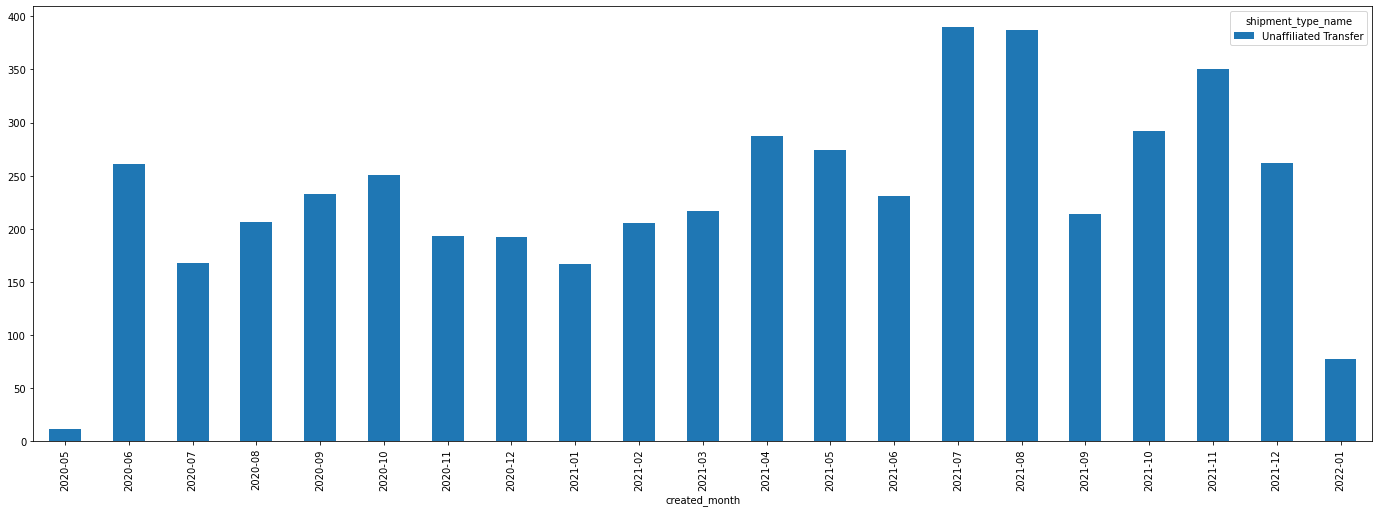

In [14]:
# Incoming transfer packages by shipment type name
company_incoming_transfer_packages_dataframe.groupby(['created_month', 'shipment_type_name'])['package_id'].count().unstack().plot.bar(figsize=(24, 8), stacked=True)

<AxesSubplot:xlabel='created_month'>

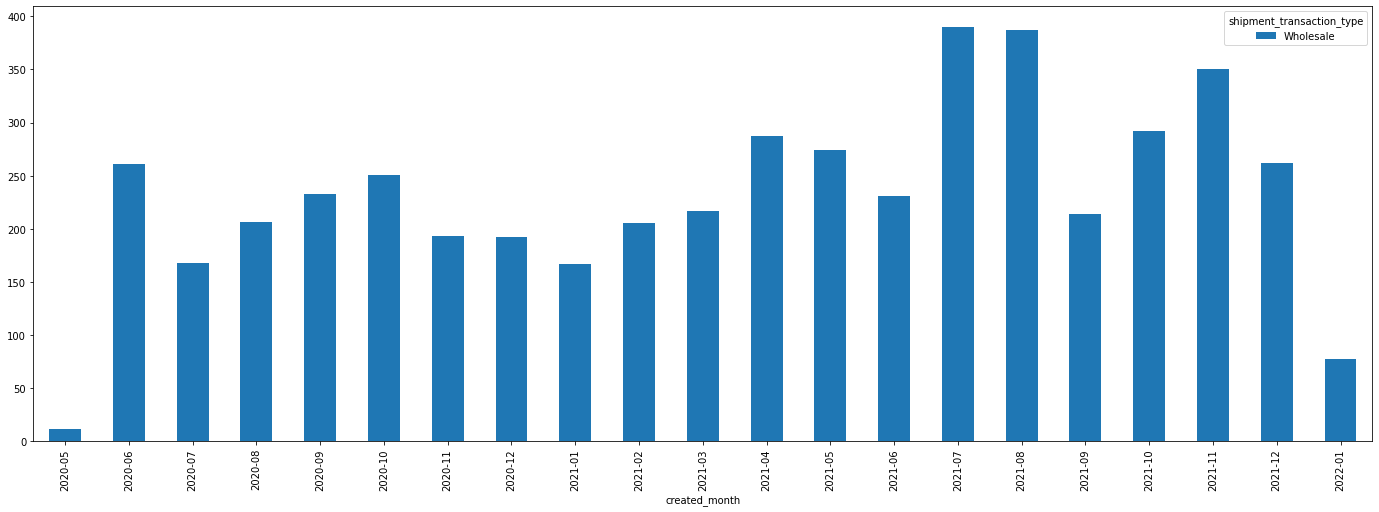

In [15]:
# Incoming transfer packages by shipment_transaction_type
company_incoming_transfer_packages_dataframe.groupby(['created_month', 'shipment_transaction_type'])['package_id'].count().unstack().plot.bar(figsize=(24, 8), stacked=True)

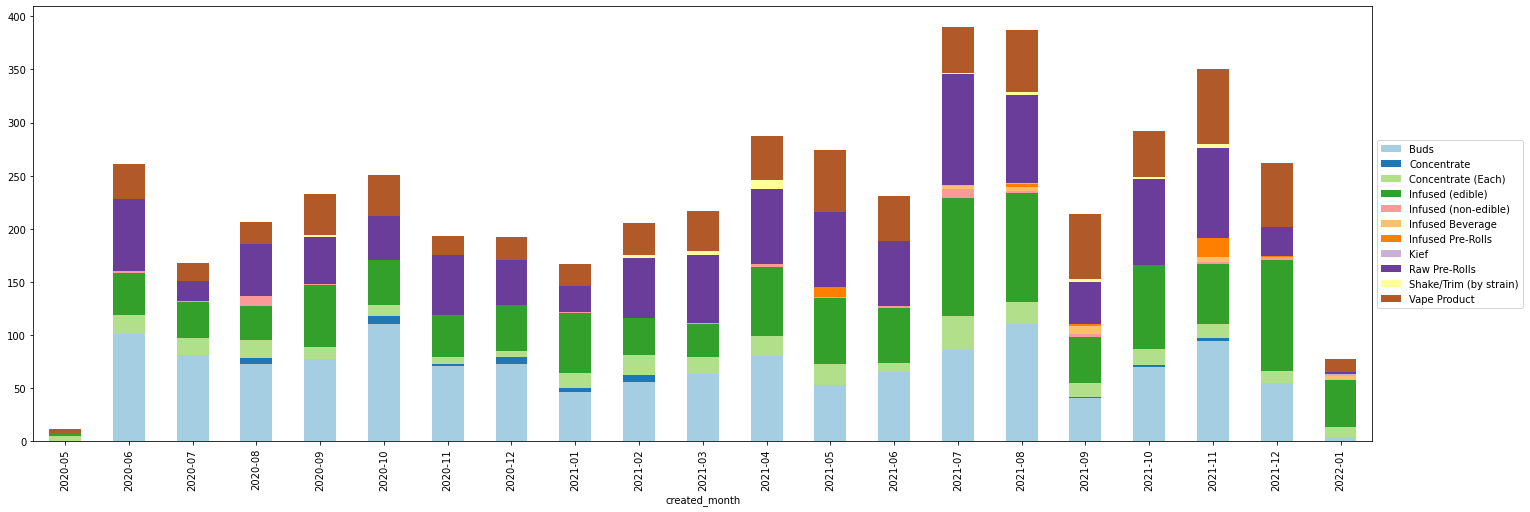

In [16]:
# Incoming transfer packages by product category names
company_incoming_transfer_packages_dataframe.groupby(['created_month', 'product_category_name'])['package_id'].count().unstack().plot.bar(figsize=(24, 8), stacked=True,colormap='Paired')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


## Check 2: receiver wholesale price coverage

In [17]:
def check_receiver_wholesale_price_coverage(incoming_transfer_df: pd.DataFrame) -> float:
    rwp_exists_count = incoming_transfer_df[incoming_transfer_df['receiver_wholesale_price'].notnull()].shape[0]
    total_count = incoming_transfer_df.shape[0]
    rwp_coverage = round(rwp_exists_count / total_count, 2) * 100
    print(f'{rwp_coverage}% of incoming transfer packages have receiver wholesale price')
    return rwp_coverage

In [18]:
rwp_coverage = check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


98.0% of incoming transfer packages have receiver wholesale price


# Plot Sales GMV month-over-month 

In [19]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

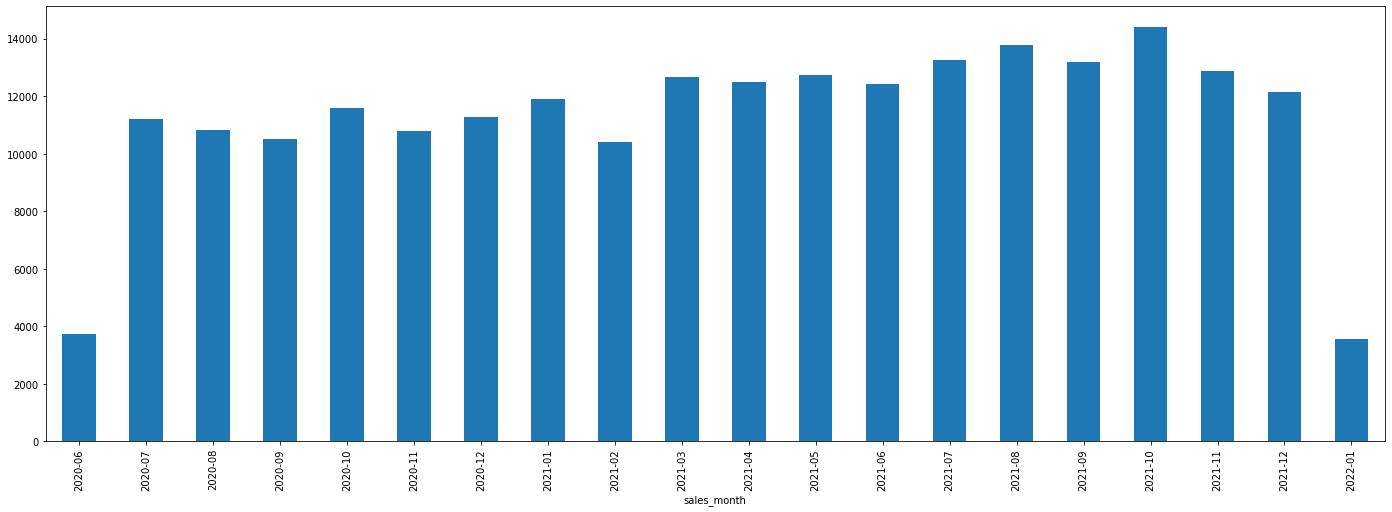

In [20]:
company_sales_receipts_dataframe.groupby(['sales_month'])['receipt_number'].count().plot.bar(figsize=(24, 8))

<AxesSubplot:xlabel='sales_month'>

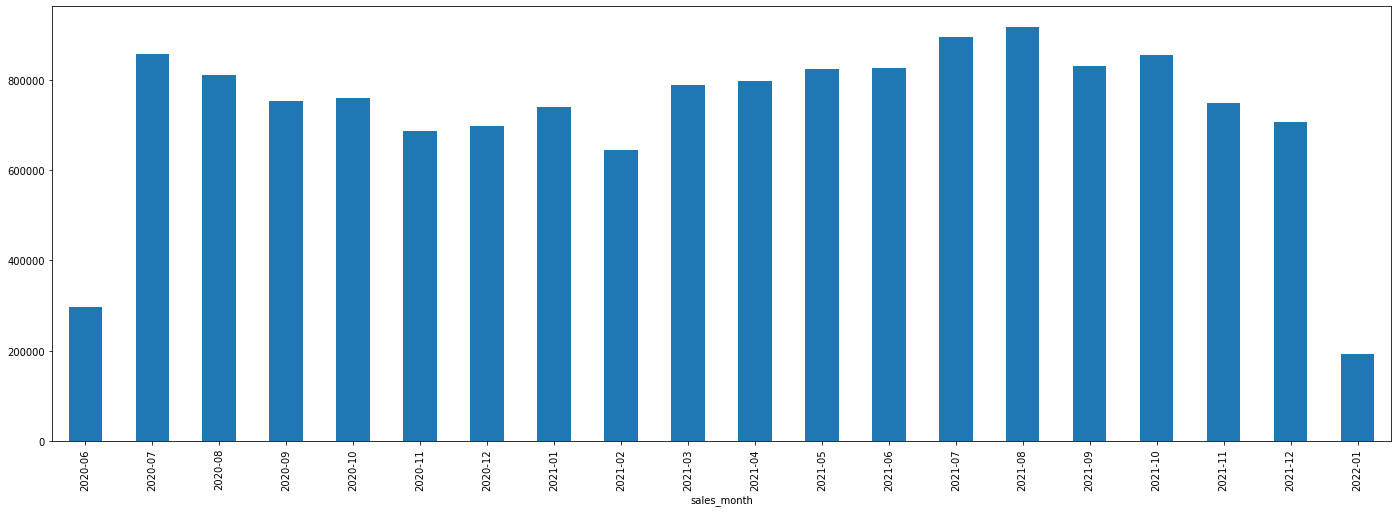

In [21]:
company_sales_receipts_dataframe.groupby(['sales_month'])['total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

## Sales GMV month-over-month from metrc_sales_transactions

In [22]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [23]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

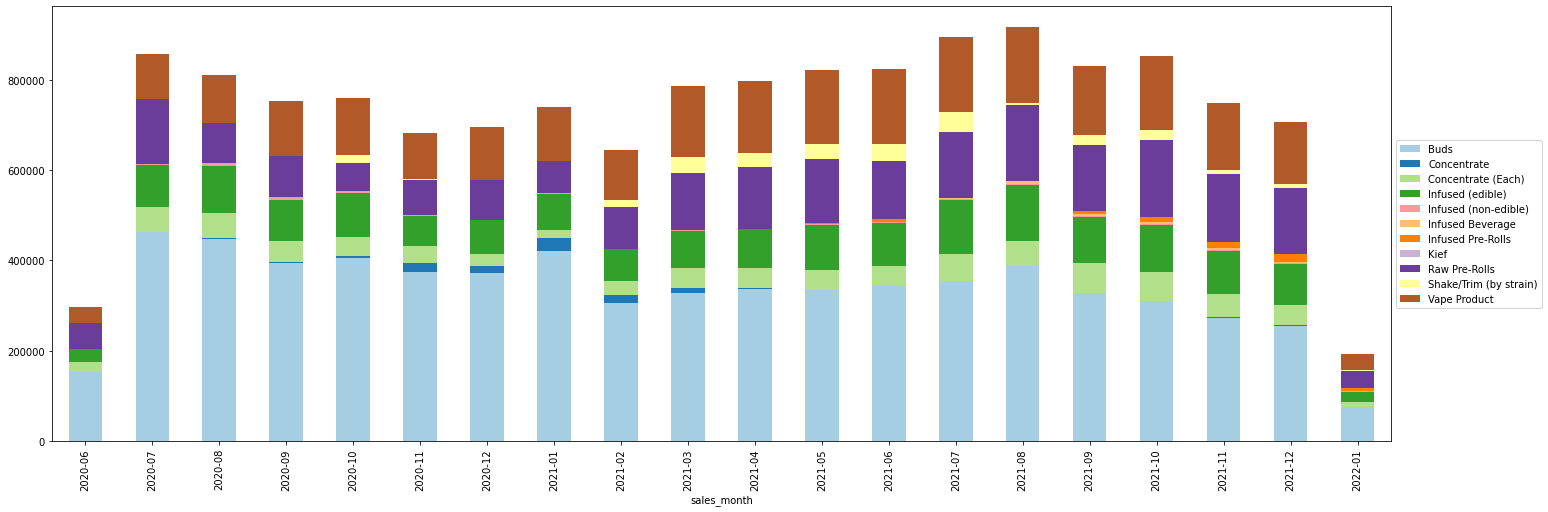

In [24]:
# Sales GMV month-over-month by product category name
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month', 'tx_product_category_name'])['tx_total_price'].sum().unstack().plot.bar(figsize=(24, 8), stacked=True,colormap = 'Paired')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))



<AxesSubplot:xlabel='sales_month'>

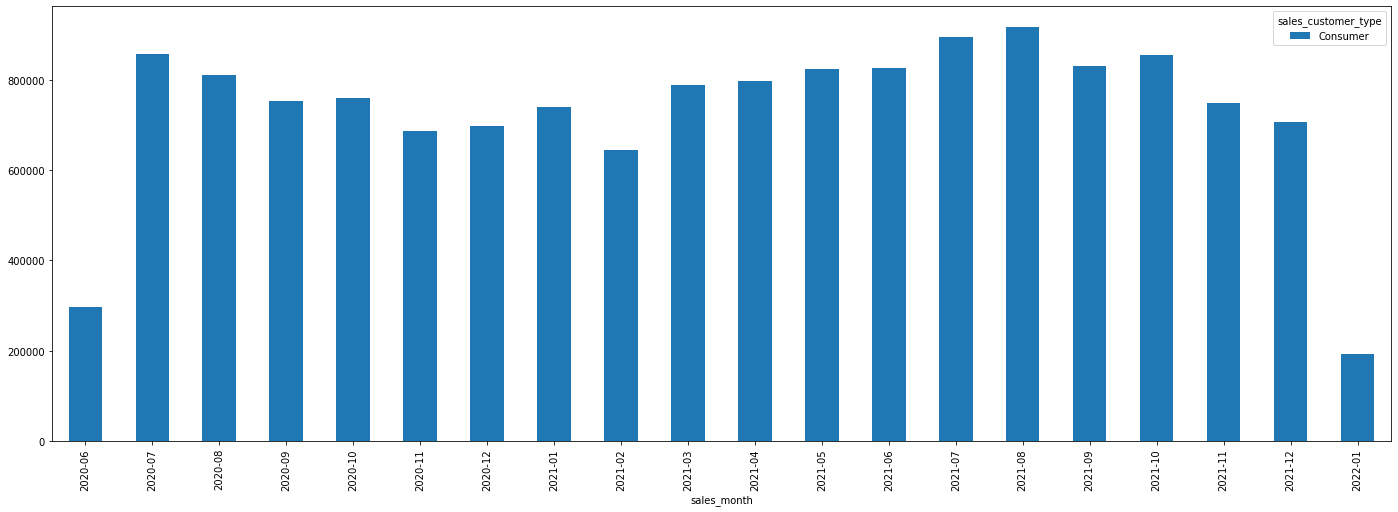

In [25]:
## View consumer vs medicinal breakdown by month.
is_sales_customer_type_breakdown_visible = True
result = None
if is_sales_customer_type_breakdown_visible:
    result = company_sales_receipts_dataframe.groupby(['sales_month', 'sales_customer_type'])['total_price'].sum().unstack().plot.bar(figsize=(24, 8), stacked=True)
result

## Check 3: trxns missing incoming transfer packages

In [26]:
def check_incoming_transfer_package_coverage(incoming_transfer_df: pd.DataFrame,sales_df: pd.DataFrame) -> Tuple[List,pd.DataFrame]:
    package_transfer_sales_merged = pd.merge(sales_df,incoming_transfer_df,left_on='tx_package_id', right_on='package_id', how='left')
    package_transfer_sales_merged_missed = package_transfer_sales_merged[package_transfer_sales_merged['package_id'].isnull()]
    count_trxn_missed = package_transfer_sales_merged_missed.shape[0]
    count_total_trxn = sales_df.shape[0]
    missed_ratio = count_trxn_missed/ count_total_trxn
    print(f'# transactions missing incoming transfer package: {count_trxn_missed} ({count_trxn_missed / count_total_trxn * 100}%)')
    print(f'# transactions total: {count_total_trxn}')
    return missed_ratio,package_transfer_sales_merged_missed

In [27]:
#deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)
#deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [28]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 44324 (11.083105790100118%)
# transactions total: 399924


In [29]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count

sales_month
2020-06     382
2020-07     479
2020-08     123
2020-09    1558
2020-10    3705
2020-11    1789
2020-12    1826
2021-01    1668
2021-02    1308
2021-03    2054
2021-04    1180
2021-05    1544
2021-06    2436
2021-07    2954
2021-08    3421
2021-09    3178
2021-10    2692
2021-11    2914
2021-12    2287
2022-01     770
dtype: int64

## Check 4: Receipts missing metrc_sales_transactions

In [30]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [31]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.1
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 249 (0.11033028189608571%)
# receipts total: 225686


In [32]:
month_to_missing_count

{'2021-11': 3,
 '2021-10': 36,
 '2021-07': 13,
 '2021-06': 32,
 '2021-05': 45,
 '2021-04': 27,
 '2021-03': 22,
 '2020-12': 42,
 '2020-11': 29}

In [33]:
for example_mismatch_over_receipt in example_mismatch_over_receipts[:10]:
    receipt_number, receipt_transactions = example_mismatch_over_receipt
    first_receipt_transaction = receipt_transactions[0]
    print(receipt_number)
    for receipt_transaction in receipt_transactions:
        print(receipt_transaction)
    print('---')

## Check 5: receiver wholesale price outlier check

In [34]:
def check_per_unit_incoming(incoming_transfer_df: pd.DataFrame) -> Tuple[pd.DataFrame,pd.DataFrame]:
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    # by package ID
    per_unit_incoming_package_sort = incoming_transfer_df[['package_id','per_unit_incoming']].groupby(['package_id']).mean().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_package_top5 = per_unit_incoming_package_sort[0:5]
    print('printing per unit incoming by package ID summary ...')
    print(f'max per unit incoming: {per_unit_incoming_package_sort["per_unit_incoming"][0]}' + f' from package ID: {per_unit_incoming_package_sort["package_id"][0]}')
    print(f'min per unit incoming: {per_unit_incoming_package_sort["per_unit_incoming"][-1:].values[0]}' + f' from package ID: {per_unit_incoming_package_sort["package_id"][-1:].values[0]}')
    #print(per_unit_incoming_package_top5)
    print('')
    
    #by product name
    per_unit_incoming_product_sort = incoming_transfer_df[['product_name','per_unit_incoming']].groupby(['product_name']).max().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_product_top5 = per_unit_incoming_product_sort[0:5]
    print('printing per unit incoming by product name summary ...')
    print(f'max per unit incoming: {per_unit_incoming_product_sort["per_unit_incoming"][0]}' + f' from product name: {per_unit_incoming_product_sort["product_name"][0]}')
    print(f'min per unit incoming: {per_unit_incoming_product_sort["per_unit_incoming"][-1:].values[0]}' + f' from product_name: {per_unit_incoming_product_sort["product_name"][-1:].values[0]}')
    #print(per_unit_incoming_product_top5)
    return per_unit_incoming_package_sort,per_unit_incoming_product_sort


In [35]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 3000.0 from package ID: 2638266
min per unit incoming: 2.6212319790301444e-05 from package ID: 1990171

printing per unit incoming by product name summary ...
max per unit incoming: 3000.0 from product name: Z Animal x Bully Kush Buds
min per unit incoming: 6.666666666666667e-05 from product_name: M00000827220: Fruit Chew Margarita Chill Strawberry 10pc


In [36]:
# top 5
per_unit_incoming_package_sort.head(5)

,package_id,per_unit_incoming
0,2638266,3000.0
1,2513092,2500.0
2,2645141,2200.0
3,2638147,2200.0
4,1206862,100.0


In [37]:
# bottom 5
per_unit_incoming_package_sort.tail(5)

,package_id,per_unit_incoming
4826,1676958,0.000067
4827,1680240,0.000067
4828,1682516,0.000067
4829,1677430,0.000067
4830,1990171,0.000026


## COGS analysis

In [38]:
def cogs_analysis(df_in:pd.DataFrame,df_out:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage']]
    return df_summary_simp,df_cogs_average_product




In [39]:
df_in = company_incoming_transfer_packages_dataframe
df_out = company_outgoing_transfer_packages_dataframe
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [40]:
df_summary_simp,df_cogs_average_product = cogs_analysis(df_in,df_out,df_inventory,df_sales,'monthly')

In [41]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage
0,2020-06,297965.49,159257.675714,138707.814286,0.465516,7604,612,6992,1.000000
1,2020-07,856255.46,415752.927679,440502.532321,0.514452,21798,628,21170,1.000000
2,2020-08,810926.75,379750.665343,431176.084657,0.531708,19411,123,19288,1.000000
3,2020-09,752146.63,339350.138120,412796.491880,0.548824,18133,2015,16118,1.000000
4,2020-10,759051.75,352014.396218,407037.353782,0.536245,20457,4358,16099,0.998243
5,2020-11,683023.02,343952.363266,339070.656734,0.496426,18224,1789,16435,0.998411
6,2020-12,694512.14,349549.501110,344962.638890,0.496698,19314,1895,17419,0.999172
7,2021-01,739681.95,366559.622327,373122.327673,0.504436,19538,1697,17841,1.000000
8,2021-02,644566.19,343858.980412,300707.209588,0.466527,17191,1402,15789,1.000000
9,2021-03,786718.17,415577.418532,371140.751468,0.471758,22633,2251,20382,1.000000


## check items sold at discount (sales price < cost)

In [42]:
def calculate_discount(df_sales_with_incoming_filled:pd.DataFrame) -> pd.DataFrame:
    # receipt count
    total_receipt_count = df_sales_with_incoming_filled.groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
    discounted = df_sales_with_incoming_filled[(df_sales_with_incoming_filled['per_unit_incoming'] > df_sales_with_incoming_filled['per_unit'])|(df_sales_with_incoming_filled['per_unit_product'] > df_sales_with_incoming_filled['per_unit'])]
    total_discounted_receipt_count = discounted[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
    discount_rate = total_discounted_receipt_count / total_receipt_count
    discount_rate_df = pd.DataFrame([total_receipt_count,total_discounted_receipt_count,discount_rate]).T.reset_index()
    discount_rate_df.columns = ['sales_month','total_receipt_count','total_discounted_receipts_count','discount_rate']

    # dollar amount
    total_receipt_amount = df_sales_with_incoming_filled[['sales_month','tx_total_price']].groupby(['sales_month']).sum().reset_index()
    total_receipt_amount.columns = ['sales_month','total_receipt_amount']
    total_discounted_receipt_amount = discounted[['sales_month','tx_total_price']].groupby(['sales_month']).sum().reset_index()
    total_discounted_receipt_amount.columns = ['sales_month','total_discounted_receipt_amount']
    discount_rate_dollar_df = total_receipt_amount.merge(total_discounted_receipt_amount,on = 'sales_month',how = 'left')
    discount_rate_dollar_df['discount_rate_dollar'] = discount_rate_dollar_df['total_discounted_receipt_amount'] / discount_rate_dollar_df['total_receipt_amount']
    discount_df = discount_rate_df.merge(discount_rate_dollar_df, on = 'sales_month',how = 'left')
    discount_df.index = discount_df.sales_month
    return discount_df
                                                                                                                                           
                                                                                                                                           
                                                                                                                                           

In [43]:
discount_rate = calculate_discount(df_cogs_average_product)

<ipython-input-44-6d050e7aa434>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


Text(0.5, 1.0, 'discount rate')

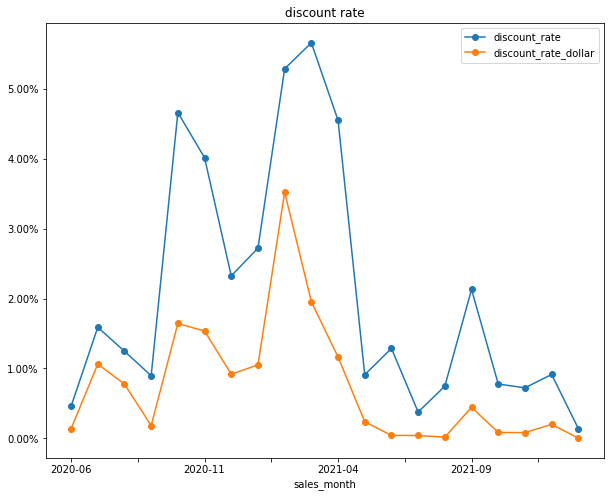

In [44]:
ax = discount_rate[['discount_rate','discount_rate_dollar']].plot(marker = 'o',figsize = (10,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.title('discount rate')

## Check items refunded (transaction total < 0)

In [45]:
def calculate_refund(df_sales_with_incoming_filled:pd.DataFrame) -> pd.DataFrame:
    #total receipt count
    count_receipt = df_sales_with_incoming_filled[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
    refunded = df_sales_with_incoming_filled[df_sales_with_incoming_filled['tx_total_price'] < 0]
    count_refund_receipt = refunded[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
    refund_rate = count_refund_receipt / count_receipt
    refund_rate_df = pd.DataFrame([count_receipt,count_refund_receipt,refund_rate]).T.reset_index()
    refund_rate_df.columns = ['sales_month','total_receipt_count','total_refunded_receipts_count','refund_rate']
    
    # dollar amount
    total_receipt_amount = df_sales_with_incoming_filled[['sales_month','tx_total_price']].groupby(['sales_month']).sum().reset_index()
    total_receipt_amount.columns = ['sales_month','total_receipt_amount']
    total_refunded_receipt_amount = refunded[['sales_month','tx_total_price']].groupby(['sales_month']).sum().reset_index()
    total_refunded_receipt_amount.columns = ['sales_month','total_refunded_receipt_amount']
    refund_rate_dollar_df = total_receipt_amount.merge(total_refunded_receipt_amount,on = 'sales_month',how = 'left')
    refund_rate_dollar_df['refund_rate_dollar'] = refund_rate_dollar_df['total_refunded_receipt_amount'] * -1.00 / refund_rate_dollar_df['total_receipt_amount']
    refund_df = refund_rate_df.merge(refund_rate_dollar_df, on = 'sales_month',how = 'left')
    refund_df.index = refund_df.sales_month
    return refund_df


In [46]:
refund_rate = calculate_refund(df_cogs_average_product)

<ipython-input-47-d17c67a1071c>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


Text(0.5, 1.0, 'refund rate')

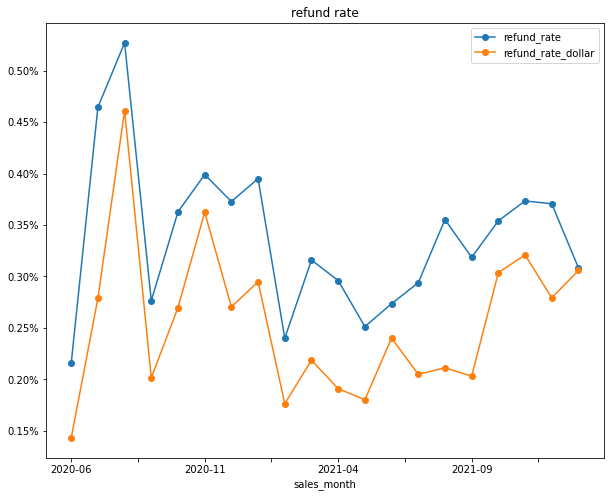

In [47]:
ax = refund_rate[['refund_rate','refund_rate_dollar']].plot(marker = 'o',figsize = (10,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.title('refund rate')

# COGS analysis with further filldown using product category name

In [48]:
def cogs_analysis_fill_by_product_category(df_in:pd.DataFrame,df_out:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> pd.DataFrame:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
        print(df_sales['sales_datetime'].min())
        print(df_sales['sales_datetime'].max())
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        print(df_sales['sales_datetime'].min())
        print(df_sales['sales_datetime'].max())
    # total # trxns    
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    # per unit price by product category name
    average_incoming_product_category = df_in_price.groupby('product_category_name')['per_unit_incoming'].mean()
    df_avg_product_cat = pd.Series(average_incoming_product_category).to_frame()
    df_avg_product_cat = df_avg_product_cat.reset_index()
    df_avg_product_cat.rename(columns={'per_unit_incoming':'per_unit_product_cat'}, inplace=True)
    
    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]
    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxns by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    # merge with (cogs by product category name)
    df_cogs_average_product_cat = pd.merge(df_cogs_average_product, df_avg_product_cat, left_on='tx_product_category_name', right_on='product_category_name', how='left')
    df_cogs_average_product_cat['total_product_cat'] = df_cogs_average_product_cat['tx_quantity_sold'] * df_cogs_average_product_cat['per_unit_product_cat']
    df_cogs_null = df_cogs_average_product_cat[df_cogs_average_product_cat['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[(df_cogs_null['per_unit_product'].notnull())]
    df_cogs_product_null = df_cogs_average_product_cat[(df_cogs_average_product_cat['per_unit_incoming'].isnull())&(df_cogs_average_product_cat['per_unit_product'].isnull())]
    df_cogs_product_cat = df_cogs_product_null[df_cogs_product_null['per_unit_product_cat'].notnull()]
    
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # sum cogs filldown by product category name
    product_cat_sum = df_cogs_product_cat.groupby('date')['total_product_cat'].sum()
    df_product_cat_sum = pd.Series(product_cat_sum).to_frame()
    df_product_cat_sum = df_product_cat_sum.reset_index()
    df_product_cat_sum.rename(columns={'total_product_cat':'product_cat_sum'}, inplace=True)
    # count # of trxn filldown by product category name
    product_cat_count = df_cogs_product_cat.groupby('date')['total_product_cat'].count()
    df_product_cat_count = pd.Series(product_cat_count).to_frame()
    df_product_cat_count = df_product_cat_count.reset_index()
    df_product_cat_count.rename(columns={'total_product_cat':'product_cat_count'}, inplace=True)
    df_cogs_product_cat_df = pd.merge(df_product_cat_sum, df_product_cat_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_product_cat_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    df_summary['product_cat_sum'] = df_summary['product_cat_sum'].fillna(0)
    df_summary['product_cat_count'] = df_summary['product_cat_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs + by product category name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum'] + df_summary['product_cat_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count + by product category count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count'] + df_summary['product_cat_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','product_cat_count','total_count','count_incoming', 'coverage']]
    df_summary_simp.index = df_summary_simp.date
    return df_summary_simp,df_cogs_average_product_cat




In [49]:
df_in = company_incoming_transfer_packages_dataframe
df_out = company_outgoing_transfer_packages_dataframe
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [50]:
df_summary_simp_cat,merged = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'monthly')



2020-06-12 09:14:05.617000+00:00
2022-01-09 21:00:22.930000+00:00


In [51]:
df_summary_simp_cat['package_id_perc'] = df_summary_simp_cat['count_incoming'] / df_summary_simp_cat['total_count_incoming']
df_summary_simp_cat['product_perc'] = df_summary_simp_cat['product_count'] / df_summary_simp_cat['total_count_incoming']
df_summary_simp_cat['product_cat_perc'] = df_summary_simp_cat['product_cat_count'] / df_summary_simp_cat['total_count_incoming']
df_summary_simp_cat['total'] = (df_summary_simp_cat['product_cat_count'] + df_summary_simp_cat['count_incoming'] + df_summary_simp_cat['product_count']) / df_summary_simp_cat['total_count_incoming'] 



<AxesSubplot:xlabel='date'>

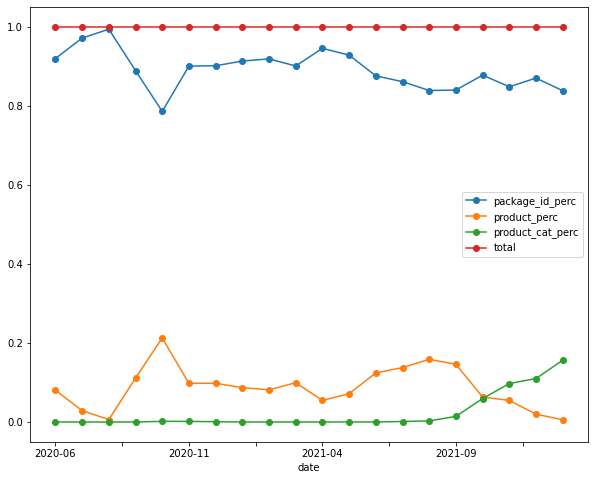

In [52]:
df_summary_simp_cat[['package_id_perc','product_perc','product_cat_perc','total']].plot(figsize = (10,8),marker = 'o')


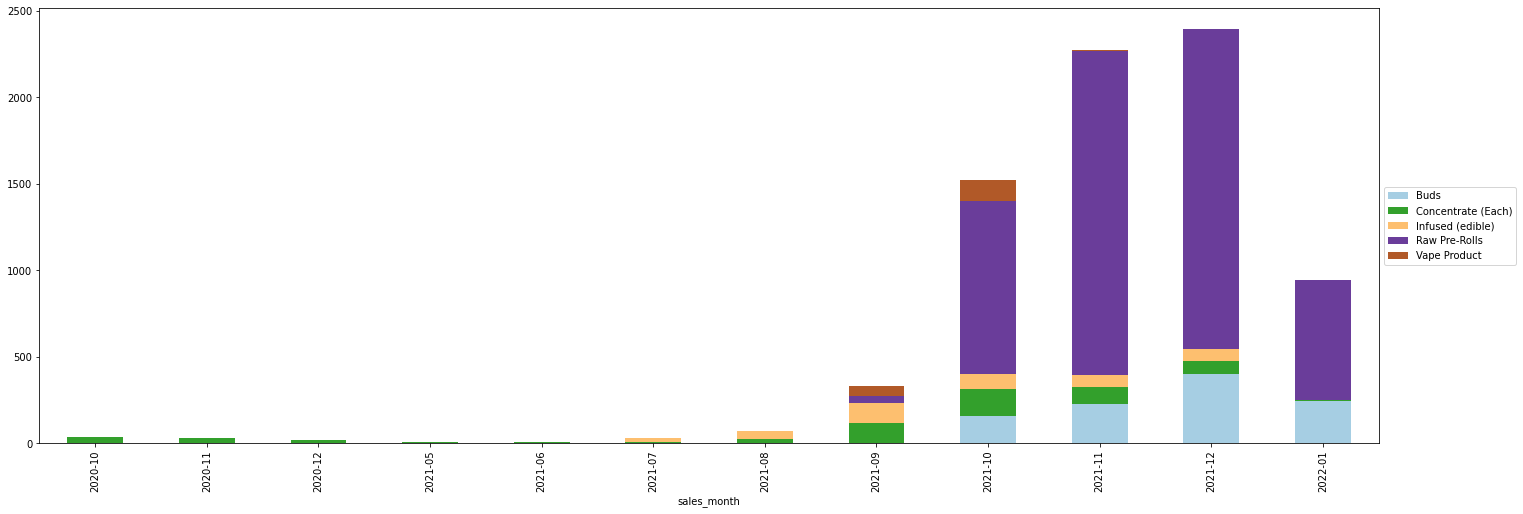

In [53]:
# what was filled by product category?
merged[(merged['per_unit_product'].isnull())&(merged['per_unit_incoming'].isnull())&(merged['per_unit_product_cat'].notnull())].groupby(['sales_month', 'tx_product_category_name'])['tx_package_id'].count().unstack().plot.bar(figsize=(24, 8), stacked=True,colormap='Paired')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


## look at the price difference

In [54]:
merged['diff1'] = merged['per_unit_incoming'] - merged['per_unit_product']
merged['diff2'] = merged['per_unit_incoming'] - merged['per_unit_product_cat']


array([[<AxesSubplot:title={'center':'diff1'}>]], dtype=object)

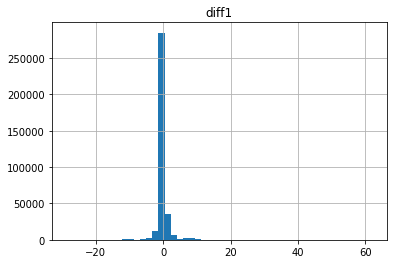

In [55]:
merged[['diff1']].hist(bins = 50)

In [56]:
merged[['diff1']].describe()

,diff1
count,355600.000000
mean,0.071387
std,2.743912
min,-28.522222
25%,-0.031250
50%,0.000000
75%,0.000000
max,61.866667


array([[<AxesSubplot:title={'center':'diff2'}>]], dtype=object)

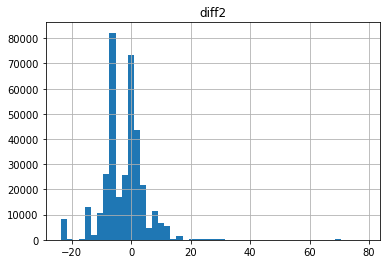

In [57]:
merged[['diff2']].hist(bins = 50)

In [58]:
merged[['diff2']].describe()

,diff2
count,355600.000000
mean,-2.342947
std,7.063531
min,-23.660208
25%,-6.136840
50%,-2.066658
75%,1.432017
max,78.715095


In [ ]:
#test = merged[merged['product_category_name'] == 'Raw Pre-Rolls']['tx_product_name'].unique()

In [ ]:
#test_str = "Slim Pre-Roll (1g) - Sour 98"

In [ ]:
#test_str.split()

In [ ]:
#res = [i for i in test_str.split() if 'g' in i]

In [ ]:
#res[0]

In [ ]:
#df_in[['product_category_name','received_unit_of_measure']].groupby(['product_category_name','received_unit_of_measure']).count()

## Compare computed inventory vs Metrc inventory (metrc_packages)

In [ ]:
TODAY_DATE = date.today().strftime('%m/%d/%Y')
INVENTORY_DATES = [TODAY_DATE]
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0,
    'find_parent_child_relationships': False,
}
print('Today is {}'.format(TODAY_DATE))

In [ ]:
analysis_ctx = inventory_types.AnalysisContext(
    output_root_dir='tmp',
    read_params=inventory_types.ReadParams(
        use_cached_dataframes=False
    ),
    write_params=inventory_types.WriteOutputParams(
        save_download_dataframes=False
    )
)

d = util.Download()
sql_helper = util.BigQuerySQLHelper(
    ctx=analysis_ctx,
    engine=engine,
)
d.download_dataframes(
    all_dataframes_dict=download_util.AllDataframesDict(
        incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
        outgoing_transfer_packages_dataframe=company_outgoing_transfer_packages_dataframe,
        sales_transactions_dataframe=company_sales_transactions_dataframe,
        sales_receipts_dataframe=company_sales_receipts_dataframe,
        inventory_packages_dataframe=company_inventory_packages_dataframe,
    ),
    sql_helper=sql_helper
)

In [ ]:
q = util.Query(
    inventory_dates=[], # gets filled in once we have the dataframes
    transfer_packages_start_date=TRANSFER_PACKAGES_START_DATE,
    sales_transactions_start_date=SALES_TRANSACTIONS_START_DATE,
    company_name=COMPANY_IDENTIFIER,
    company_identifier=COMPANY_IDENTIFIER,
    license_numbers=[],
)

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
util.print_counts(analysis_ctx, id_to_history)

In [ ]:
date_to_inventory_packages_dataframe = {}

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
inventory_valuations = []

for inventory_date in INVENTORY_DATES:
    computed_inventory_package_records = util.create_inventory_dataframe_by_date(
        id_to_history, inventory_date, params=ANALYSIS_PARAMS)    
    computed_inventory_packages_dataframe = pandas.DataFrame(
        computed_inventory_package_records,
        columns=util.get_inventory_column_names(),
    )
    date_to_inventory_packages_dataframe[inventory_date] = computed_inventory_packages_dataframe
    inventory_valuations.append(valuations_util.get_total_valuation_for_date(
        computed_inventory_packages_dataframe=computed_inventory_packages_dataframe,
        company_incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
        inventory_date=inventory_date,
        using_nb=True,
    ))

In [ ]:
from_packages_inventory_dataframe = company_inventory_packages_dataframe[[
    'package_id',
    'packaged_date',
    'unit_of_measure',
    'product_category_name',
    'product_name',
    'quantity',
]].sort_values('package_id')

package_id_to_actual_row = {}
for index, row in from_packages_inventory_dataframe.iterrows():
    package_id_to_actual_row[str(row['package_id'])] = row
    
res = util.compare_inventory_dataframes(
    ctx=analysis_ctx,
    computed=date_to_inventory_packages_dataframe[TODAY_DATE],
    actual=from_packages_inventory_dataframe,
    options={
        'num_errors_to_show': 10,
        'accept_computed_when_sold_out': True
    }
)

In [ ]:
inventory_cost_valuation = valuations_util.get_inventory_valuation(
    inventory_packages_dataframe=company_inventory_packages_dataframe,
    incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
)
print(f'Cost valuation of Metrc-reported inventory as of today: ${round(inventory_cost_valuation, 2)}')

## Export data

In [ ]:
# Flip flag if you want to export data to files.
is_export_enabled = False

In [ ]:
import time
from datetime import date

TODAY_DATE = date.today().strftime('%m-%d-%Y')
NOW = int(time.time())

export_incoming_transfer_packages_dataframe = company_incoming_transfer_packages_dataframe

date_columns = export_incoming_transfer_packages_dataframe.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
    export_incoming_transfer_packages_dataframe[date_column] = export_incoming_transfer_packages_dataframe[date_column].dt.date

incoming_transfer_packages_file_name = f'~/Downloads/{COMPANY_IDENTIFIER}_incoming_transfer_packages_{TODAY_DATE}_{NOW}'

export_inventory_packages_dataframe = company_inventory_packages_dataframe

date_columns = export_inventory_packages_dataframe.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
    export_inventory_packages_dataframe[date_column] = export_inventory_packages_dataframe[date_column].dt.date

inventory_packages_file_name = f'~/Downloads/{COMPANY_IDENTIFIER}_inventory_packages_{TODAY_DATE}_{NOW}'

export_sales_transactions_dataframe = deduped_sales_receipts_with_transactions_dataframe

date_columns = export_sales_transactions_dataframe.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
    export_sales_transactions_dataframe[date_column] = export_sales_transactions_dataframe[date_column].dt.date

sales_transactions_file_name = f'~/Downloads/{COMPANY_IDENTIFIER}_sales_transactions_{SALES_TRANSACTIONS_START_DATE}_{TODAY_DATE}_{NOW}'

if is_export_enabled:
    num_incoming_transfer_packages = len(export_incoming_transfer_packages_dataframe.index)
    print(f'Exporting {num_incoming_transfer_packages} incoming transfer packages to files...')
    export_incoming_transfer_packages_dataframe.reset_index().to_excel(f'{incoming_transfer_packages_file_name}.xlsx')
    export_incoming_transfer_packages_dataframe.reset_index().to_csv(f'{incoming_transfer_packages_file_name}.csv')
    print(f'Exported {num_incoming_transfer_packages} incoming transfer packages to files')

    num_inventory_packages = len(export_inventory_packages_dataframe.index)
    print(f'Exporting {num_inventory_packages} inventory packages to files...')
    export_inventory_packages_dataframe.reset_index().to_excel(f'{inventory_packages_file_name}.xlsx')
    export_inventory_packages_dataframe.reset_index().to_csv(f'{inventory_packages_file_name}.csv')
    print(f'Exported {num_inventory_packages} inventory packages to files')

    num_sales_transactions = len(export_sales_transactions_dataframe.index)
    print(f'Exporting {num_sales_transactions} sales transactions to files...')
    export_inventory_packages_dataframe.reset_index().to_excel(f'{sales_transactions_file_name}.xlsx')
    export_inventory_packages_dataframe.reset_index().to_csv(f'{sales_transactions_file_name}.csv')
    print(f'Exported {num_sales_transactions} sales transactions to files')